# ▷ 바로가기 이동

### 1. [LMS Node Review](#6-4.-실습-(1)-데이터-다듬기)

### 2. [Exploration Project 06. 작사가 인공지능 만들기](#exploration-project-06)

바로가기 기능은 local에서 동작

In [1]:
## 구글 드라이브 연결# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 6-4. 실습 (1) 데이터 다듬기

준비된 데이터는 1Mb 남짓한 텍스트 파일입니다.

GPT-2를 학습시킬 때의 100Gb 가까이 되는 수준과는 아주 거리가 멉니다만, 

멋진 셰익스피어 같은 극작가 언어 모델이 탄생하길 기대해 봅니다.

우선 실습에 사용할 라이브러리를 불러와 주세요. 

그리고 방금 준비한 파일의 내용을 확인해 봅시다.

In [2]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함 (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)
# re: Regular Expression의 줄임말로, 파이썬 정규표현식을 사용하기 위한 모듈
# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공
# tensorflow(TensorFlow): 데이터 흐름 프로그래밍을 위한 라이브러리. 데이터 그래프를 수치적으로 연산하기 위해 구글에서 만든 오픈 소스 라이브러리.
import os, re 
import numpy as np
import tensorflow as tf

# os 모듈에 있는 getenv() 함수를 이용하여 읽고싶은 파일의 경로를 file_path에 저장
# 파일을 읽기모드로 열고
# 라인 단위로 끊어서 list 형태로 읽어옵니다.
file_path = '/content/drive/MyDrive/Colab Notebooks/EXP_06/lyricist/Data/shakespeare.txt'
with open(file_path, "r") as f:
    raw_corpus = f.read().splitlines()

# 앞에서부터 10라인만 화면에 출력해 볼까요?
print(raw_corpus[:9])

['First Citizen:', 'Before we proceed any further, hear me speak.', '', 'All:', 'Speak, speak.', '', 'First Citizen:', 'You are all resolved rather to die than to famish?', '']


경로를 따라 데이터를 읽어오면 데이터가 어떻게 생겼는지 눈으로 확인할 수 있습니다. 

완벽한 연극 대본이군요! 

하지만 우린 문장(대사) 만을 원하므로 화자 이름이나 공백뿐인 정보는 필요가 없습니다. 

우리가 만들 언어 모델은 연극 대사를 만들어 내는 모델이거든요.

1차 필터링을 할 필요가 있겠습니다. 데이터의 형태를 자세히 살피며 필터를 구상해보죠.

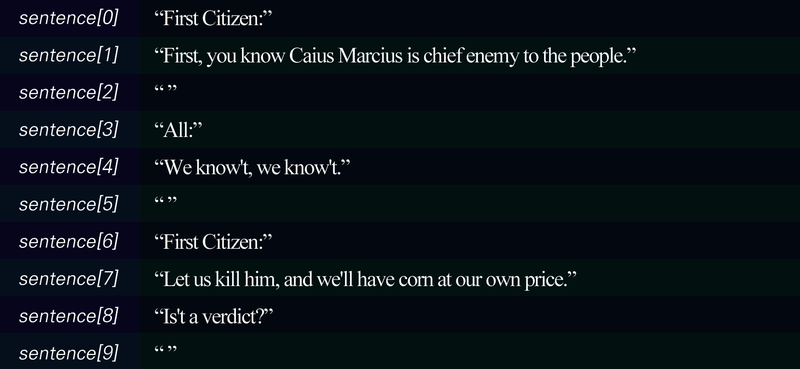

모든 문장을 하나하나 검사한다고 가정합시다.

우리가 원치 않는 문장은 화자가 표기된 문장(0, 3, 6), 그리고 공백인 문장(2, 5, 9) 입니다. 

화자가 표기된 문장은 문장의 끝이 : 로 끝나게 되어 있죠. 

일반적으로 대사가 : 로 끝나는 일은 없을테니, : 를 기준으로 문장을 제외해도 괜찮을 것 같습니다. 

그리고 공백인 문장은 길이를 검사하여 길이가 0이라면 제외를 시키죠!

In [3]:
# enumerate() 함수를 이용하여 raw_corpus list 내에 저장된 문장과 그 문장의 인덱스를 반환 (인덱스, 문장 순)
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다.

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(sentence)

Before we proceed any further, hear me speak.
Speak, speak.
You are all resolved rather to die than to famish?


우리가 원하는 문장만 성공적으로 출력됩니다.

텍스트 분류 모델에서 많이 보신 것처럼 텍스트 생성 모델에도 단어 사전을 만들게 됩니다. 

그렇다면 문장을 일정한 기준으로 쪼개야겠죠? 그 과정을 토큰화(Tokenize) 라고 합니다.

가장 심플한 방법은 띄어쓰기를 기준으로 나누는 방법이고, 우리도 그 방법을 사용할 겁니다. 

하지만 약간의 문제가 있을 수 있죠. 몇 가지 문제 케이스를 살펴보죠.

1. Hi, my name is John. *("Hi," "my", ..., "john." 으로 분리됨) - 문장부호

2. First, open the first chapter. *(First와 first를 다른 단어로 인식) - 대소문자

3. He is a ten-year-old boy. *(ten-year-old를 한 단어로 인식) - 특수문자

"1." 을 막기 위해 문장 부호 양쪽에 공백을 추가 할 거고요,

"2." 를 막기 위해 모든 문자들을 소문자로 변환 할 겁니다.

"3." 을 막기 위해 특수문자들은 모두 제거 하도록 하죠!

이런 전처리를 위해 정규표현식(Regex)을 이용한 필터링이 유용하게 사용됩니다.

In [4]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


잔, 지저분한 문장을 넣어도 예쁘게 변환해 주는 정제 함수가 완성되었습니다!

보너스로 이전 스텝에서 배운 \<start\> \<end\> 도 추가했습니다.

그러면 우리가 구축해야 할 데이터셋은 어떤 모양이 될까요?

이전 스텝에서 봤던 예를 떠올려 봅시다.

~~~
언어 모델의 입력 문장 :  <start> 나는 밥을 먹었다
언어 모델의 출력 문장 : 나는 밥을 먹었다 <end>
~~~

자연어처리 분야에서 모델의 입력이 되는 문장을 소스 문장(Source Sentence) , 

정답 역할을 하게 될 모델의 출력 문장을 타겟 문장(Target Sentence) 라고 관례적으로 부릅니다. 

각각 X_train, y_train 에 해당한다고 할 수 있겠죠?

그렇다면 우리는 위에서 만든 정제 함수를 통해 만든 데이터셋에서 토큰화를 진행한 후

끝 단어 \<end\>를 없애면 소스 문장, 첫 단어 \<start\>를 없애면 타겟 문장이 되겠죠?

이 정제 함수를 활용해서 아래와 같이 정제 데이터를 구축합니다!

In [5]:
# 여기에 정제된 문장을 모을겁니다
corpus = []

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> before we proceed any further , hear me speak . <end>',
 '<start> speak , speak . <end>',
 '<start> you are all resolved rather to die than to famish ? <end>',
 '<start> resolved . resolved . <end>',
 '<start> first , you know caius marcius is chief enemy to the people . <end>',
 '<start> we know t , we know t . <end>',
 '<start> let us kill him , and we ll have corn at our own price . <end>',
 '<start> is t a verdict ? <end>',
 '<start> no more talking on t let it be done away , away ! <end>',
 '<start> one word , good citizens . <end>']

이제 데이터는 완벽하게 준비가 된 것 같네요!

자, 새로운 언어를 배우는 상상을 해봅시다. 

영어를 전혀 모르던 그 때로 돌아가서, 다시 영어를 배우려면 어떻게 해야 할까요? 

영한사전 을 허리춤에 끼고 문장 속 단어를 하나하나 찾아가며 한국어 해석 을 적겠죠? 

이 아이디어는 인공지능에게도 똑같이 적용됩니다. 

배우고자 하는 언어 를 모국어로 표현 을 해야 공부를 할 수 있어요.

인공지능의 모국어라면 단연 숫자 겠죠. 

우리는 가르칠 언어(데이터)를 숫자로 변환해서 인공지능에게 줄 겁니다. 

이에 필요한 것은 사전 ! 굳이 명명하자면... 데숫사전...?



텐서플로우는 자연어 처리를 위한 여러 가지 모듈을 제공하는데, 우리도 그 모듈을 십분 활용할 겁니다! 

아래에서 활용하게 될 tf.keras.preprocessing.text.Tokenizer 패키지는 정제된 데이터를 토큰화하고, 

단어 사전(vocabulary 또는 dictionary라고 칭함)을 만들어주며, 

데이터를 숫자로 변환까지 한 방에 해줍니다. 

이 과정을 벡터화(vectorize) 라 하며, 숫자로 변환된 데이터를 텐서(tensor) 라고 칭합니다. 

우리가 사용하는 텐서플로우로 만든 모델의 입출력 데이터는 실제로는 모두 이런 텐서로 변환되어 처리되는 것입니다.

> &nbsp;<br>
> 텐서(tensor)는 굉장히 어려운 물리학 및 수학 개념입니다. <br>
> <br>
> 우리가 그 내용을 모두 이해할 필요는 없으나<br>
> <br>
> 아래의 웹페이지가 설명하는 간단한 개념 정도는 알고 있으면 좋습니다.<br>
> <br>
> - [Tensor란 무엇인가?](https://rekt77.tistory.com/102) <br>
> &nbsp;

In [6]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=7000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2  143   40 ...    0    0    0]
 [   2  110    4 ...    0    0    0]
 [   2   11   50 ...    0    0    0]
 ...
 [   2  149 4553 ...    0    0    0]
 [   2   34   71 ...    0    0    0]
 [   2  945   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f652bf675d0>


생성된 텐서 데이터를 3번째 행, 10번째 열까지만 출력해 봅시다.

In [7]:
print(tensor[:3, :10])

[[   2  143   40  933  140  591    4  124   24  110]
 [   2  110    4  110    5    3    0    0    0    0]
 [   2   11   50   43 1201  316    9  201   74    9]]


텐서 데이터는 모두 정수로 이루어져 있습니다. 

이 숫자는 다름 아니라, tokenizer에 구축된 단어 사전의 인덱스입니다. 

단어 사전이 어떻게 구축되었는지 아래와 같이 확인해 봅시다.

In [8]:
# tokenizer.index_word: 현재 계산된 단어의 인덱스와
# 인덱스에 해당하는 단어를 dictionary 형대로 반환
#  (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : ,
5 : .
6 : the
7 : and
8 : i
9 : to
10 : of


어떻습니까? 2번 인덱스가 바로 \<start\>였습니다. 

왜 모든 행이 2로 시작하는지 이해할 수 있겠습니다.

이제 생성된 텐서를 소스와 타겟으로 분리하여 모델이 학습할 수 있게 하겠습니다. 

이 과정도 텐서플로우 가 제공하는 모듈을 사용할 것이니, 어떻게 사용하는지만 눈여겨 봐둡시다.

텐서 출력부에서 행 뒤쪽에 0이 많이 나온 부분은 

정해진 입력 시퀀스 길이보다 문장이 짧을 경우 0으로 패딩(padding)을 채워 넣은 것입니다. 

사전에는 없지만 0은 바로 패딩 문자 \<pad\>가 될 것입니다.

In [9]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0
   0   0]
[143  40 933 140 591   4 124  24 110   5   3   0   0   0   0   0   0   0
   0   0]


corpus 내의 첫 번째 문장에 대해 생성된 소스와 타겟 문장을 확인해 보았습니다. 

예상대로 소스는 2(\<start\>)에서 시작해서 3(\<end\>)으로 끝난 후 0(\<pad\>)로 채워져 있습니다. 

하지만 타겟은 2로 시작하지 않고 소스를 왼쪽으로 한 칸 시프트 한 형태를 가지고 있습니다.



마지막으로 우리는 데이터셋 객체를 생성할 것입니다. 

그동안 우리는 model.fit(x_train, y_train, ...) 형태로

Numpy Array 데이터셋을 생성하여 model에 제공하는 형태의 학습을 많이 진행해 왔습니다. 

그러나 텐서플로우를 활용할 경우 텐서로 생성된 데이터를 이용해

tf.data.Dataset객체를 생성하는 방법을 흔히 사용합니다.

tf.data.Dataset객체는 텐서플로우에서 사용할 경우

데이터 입력 파이프라인을 통한 속도 개선 및 각종 편의 기능을 제공하므로

꼭 사용법을 알아 두시기를 권합니다.

우리는 이미 데이터셋을 텐서 형태로 생성해 두었으므로, 

tf.data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성할 것입니다.

In [10]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = len(src_input) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 7000개와, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 7000개로 선언했기 때문에, tokenizer.num_words의 값은 7000
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((src_input, tgt_input))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 20), dtype=tf.int32, name=None), TensorSpec(shape=(256, 20), dtype=tf.int32, name=None))>

이번 스텝에서 데이터셋을 생성하기 위해 거쳐 온 과정을 잘 기억해 두시길 바랍니다.



- 정규표현식을 이용한 corpus 생성

- tf.keras.preprocessing.text.Tokenizer를 이용해 corpus를 텐서로 변환

- tf.data.Dataset.from_tensor_slices()를 이용해 corpus 텐서를 tf.data.Dataset객체로 변환

dataset을 얻음으로써 데이터 다듬기 과정은 끝났습니다.

tf.data.Dataset에서 제공하는 shuffle(), batch() 등 다양한 데이터셋 관련 기능을 손쉽게 이용할 수 있게 되었군요.


이 모든 일련의 과정을 텐서플로우에서의 데이터 전처리 라 칭합니다!




<hr>

## 6-5. 실습 (2) 인공지능 학습시키기


> &nbsp;<br>
> 우리가 인공지능이라고 부르는 것은 <br>
> <br>
> 인공신경망이자 딥러닝 네트워크이자 이번 코스에선 순환신경망이기도 하고...<br>
> <br>
> ... 너무 많은 이름이 같은 의미를 담고 있습니다.<br>
> <br>
> 따라서 지금부터 우리가 만들고자 하는 인공지능을 모델(model)이라고 칭하겠습니다.<br>
> <br>
> 실제로도 다들 모델이라고 한답니다.<br>
> &nbsp;

우리가 만들 모델의 구조도는 아래와 같습니다.

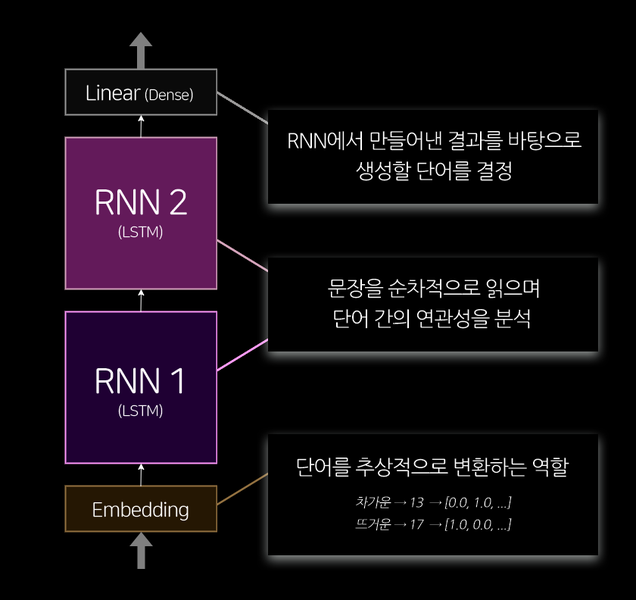

우리가 만들 모델은 tf.keras.Model을 Subclassing하는 방식으로 만들 것입니다. 

위 그림에서 설명한 것처럼 우리가 만들 모델에는

1개의 Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있습니다.

각 레이어의 기능을 확실히 이해하는 것은 나중에 하고, 

지금은 구조도에 설명된 정도의 간단한 이해만 가지고 갑시다.

In [11]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!   
embedding_size = 256 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.

# tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 


텍스트 분류 모델을 다루어 보셨다면 Embedding 레이어의 역할에 대해서는 낯설지 않을 것입니다. 

우리 입력 텐서에는 단어 사전의 인덱스가 들어 있습니다. 

Embedding 레이어는 이 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔 줍니다. 

이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현(representation)으로 사용됩니다.

위 코드에서 embedding_size 는 워드 벡터의 차원수, 즉 단어가 추상적으로 표현되는 크기입니다. 

만약 그 크기가 2라면 예를 들어

- 차갑다: [0.0, 1.0]

- 뜨겁다: [1.0, 0.0]

- 미지근하다: [0.5, 0.5]

정도의 구분이 가능하겠군요. 

값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만, 

그만큼 충분한 데이터가 주어지지 않으면 오히려 혼란만을 야기할 수 있습니다. 

이번 실습에서는 256이 적당해 보이네요.

LSTM 레이어의 hidden state 의 차원수인 hidden_size 도 같은 맥락입니다. 

hidden_size 는 모델에 얼마나 많은 일꾼을 둘 것인가? 로 이해해도 크게 엇나가지 않습니다. 

그 일꾼들은 모두 같은 데이터를 보고 각자의 생각을 가지는데, 

역시 충분한 데이터가 주어지면 올바른 결정을 내리겠지만 

그렇지 않으면 배가 산으로 갈 뿐 입니다. 

이번 실습에는 1024가 적당해보이는군요.

<hr>

우리의 model은 아직 제대로 build되지 않았습니다. 

model.compile()을 호출한 적도 없고, 

아직 model의 입력 텐서가 무엇인지 제대로 지정해 주지도 않았기 때문입니다.

그런 경우 아래와 같이 model에 데이터를 아주 조금 태워 보는 것도 방법입니다. 

model의 input shape가 결정되면서 model.build()가 자동으로 호출됩니다.

In [12]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for src_sample, tgt_sample in dataset.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(src_sample)

<tf.Tensor: shape=(256, 20, 7001), dtype=float32, numpy=
array([[[ 2.32616494e-05, -1.22750193e-04, -1.69817766e-04, ...,
          1.13021772e-04, -2.52977334e-04,  1.37338560e-04],
        [ 3.19418818e-04,  2.47236894e-04, -6.01903361e-04, ...,
          1.82068543e-05, -6.73622941e-04,  2.40695212e-04],
        [ 5.71415818e-04,  4.14402079e-04, -6.71346963e-04, ...,
          1.29738428e-05, -8.86049354e-04,  4.08718333e-05],
        ...,
        [-3.90152738e-04,  2.36608577e-03, -1.79756114e-06, ...,
         -1.15378108e-03, -1.27611434e-04, -9.32673502e-05],
        [-3.43089050e-04,  2.15766719e-03,  4.95294400e-04, ...,
         -1.41749729e-03,  1.35448237e-04, -1.02063343e-04],
        [-2.79581203e-04,  1.90434034e-03,  9.43309802e-04, ...,
         -1.67027849e-03,  3.38782876e-04, -1.16862757e-04]],

       [[ 2.32616494e-05, -1.22750193e-04, -1.69817766e-04, ...,
          1.13021772e-04, -2.52977334e-04,  1.37338560e-04],
        [-3.96414107e-04, -1.01057027e-04, -3.

모델의 최종 출력 텐서 shape를 유심히 보면 shape=(256, 20, 7001)임을 알 수 있습니다.

7001은 Dense 레이어의 출력 차원수입니다. 

7001개의 단어 중 어느 단어의 확률이 가장 높을지를 모델링해야 하기 때문입니다.

256은 이전 스텝에서 지정한 배치 사이즈입니다. 

dataset.take(1)를 통해서 1개의 배치, 즉 256개의 문장 데이터를 가져온 것입니다.

그렇다면 20은 무엇을 의미할까요? 

비밀은 바로 tf.keras.layers.LSTM(hidden_size, return_sequences=True)로 호출한

LSTM 레이어에서 return_sequences=True이라고 지정한 부분에 있습니다. 

즉, LSTM은 자신에게 입력된 시퀀스의 길이만큼 동일한 길이의 시퀀스를 출력한다는 의미입니다. 

만약 return_sequences=False였다면 LSTM 레이어는 1개의 벡터만 출력했을 것입니다.

그런데 문제는, 우리의 모델은 입력 데이터의 시퀀스 길이가 얼마인지 모른다는 점입니다. 

모델을 만들면서 알려준 적도 없습니다. 

그럼 20은 언제 알게된 것일까요? 

네, 그렇습니다. 데이터를 입력받으면서 비로소 알게 된 것입니다. 

우리 데이터셋의 max_len이 20으로 맞춰져 있었던 것입니다.

In [13]:
# 모델의 구조를 확인합니다.
model.summary()

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  1792256   
                                                                 
 lstm (LSTM)                 multiple                  5246976   
                                                                 
 lstm_1 (LSTM)               multiple                  8392704   
                                                                 
 dense (Dense)               multiple                  7176025   
                                                                 
Total params: 22,607,961
Trainable params: 22,607,961
Non-trainable params: 0
_________________________________________________________________


이제 드디어 model.summary()를 호출할 수 있게 되었습니다. 

그런데 호출해 보니 그동안 많이 보았던 것과는 다른 점이 있습니다. 

우리가 궁금했던 Output Shape를 정확하게 알려주지 않습니다. 

바로 위에서 설명한 이유 때문입니다. 

우리의 모델은 입력 시퀀스의 길이를 모르기 때문에 Output Shape를 특정할 수 없는 것입니다.

하지만 모델의 파라미터 사이즈는 측정됩니다. 대략 22million 정도 되는군요. 

참고로 서두에 소개했던 GPT-2의 파라미터 사이즈는, 1.5billion입니다. 

우리 모델의 100배까지는 안되더라도 수십배가 넘는군요. 

놀라지 마세요. GPT-3의 파라미터 사이즈는 GPT-2의 100배니까요.

<hr>

이제 모델이 학습할 준비가 완료되었습니다. 

아래 코드를 실행해 모델을 학습시켜보세요!

> &nbsp;<br>
> 학습엔 15분 정도 소요됩니다(GPU 환경 기준). <br>
> <br>
> 간단한 스트레칭과 커피 한 잔을 만들어 오기에 적당한 시간이죠.<br>
> <br>
> 혹시라도 학습에 지나치게 많은 시간이 소요된다면 tf.test.is_gpu_available() 소스를 실행해<br>
> <br>
> 텐서플로우가 GPU를 잘 사용하고 있는지 확인하시길 바랍니다!<br>
> &nbsp;

In [14]:
#tf.test.is_gpu_available() ## deprecated

import tensorflow as tf
tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7581654483941385610
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 16137322496
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1794234693039898121
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
xla_global_id: 416903419
]


In [15]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다

# Adam 알고리즘을 구현하는 optimzier이며 어떤 optimzier를 써야할지 모른다면 Adam을 쓰는 것도 방법이다.
# 우리가 학습을 할 때 최대한 틀리지 않는 방향으로 학습을 해야한다.
# 여기서 얼마나 틀리는지(loss)를 알게하는 함수가 손실함수 이다.
# 이 손실함수의 최소값을 찾는 것을 학습의 목표로 하며 여기서 최소값을 찾아가는 과정을 optimization 이라하고
# 이를 수행하는 알고리즘을 optimizer(최적화)라고 한다.

optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)
# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.
model.fit(dataset, epochs=30) # 만들어둔 데이터셋으로 모델을 학습한다. 30번 학습을 반복하겠다는 의미다.

Epoch 1/30
93/93 [==============================] - 13s 102ms/step - loss: 3.4657
Epoch 2/30
93/93 [==============================] - 9s 101ms/step - loss: 2.8017
Epoch 3/30
93/93 [==============================] - 9s 101ms/step - loss: 2.6959
Epoch 4/30
93/93 [==============================] - 9s 101ms/step - loss: 2.5977
Epoch 5/30
93/93 [==============================] - 9s 101ms/step - loss: 2.5347
Epoch 6/30
93/93 [==============================] - 9s 101ms/step - loss: 2.4844
Epoch 7/30
93/93 [==============================] - 9s 101ms/step - loss: 2.4286
Epoch 8/30
93/93 [==============================] - 9s 101ms/step - loss: 2.3729
Epoch 9/30
93/93 [==============================] - 9s 101ms/step - loss: 2.3199
Epoch 10/30
93/93 [==============================] - 9s 101ms/step - loss: 2.2710
Epoch 11/30
93/93 [==============================] - 9s 101ms/step - loss: 2.2222
Epoch 12/30
93/93 [==============================] - 9s 101ms/step - loss: 2.1751
Epoch 13/30
93/93 [=====

Loss는 모델이 오답을 만들고 있는 정도라고 생각하셔도 좋습니다

(그렇다고 Loss가 1일 때 99%를 맞추고 있다는 의미는 아닙니다). 

오답률이 감소하고 있으니 학습이 잘 진행되고 있다 고 해석할 수 있죠!

학습이 완료되었다면 이제 모델을 평가해 봅시다.

<hr>

## 6-6. 실습 (3) 잘 만들어졌는지 평가하기

모델이 작문을 잘하는지 컴퓨터 알고리즘이 평가하는 것은 무리가 있습니다. 

만약에 그게 가능했다면 우리가 지금껏 해온 독후감 숙제를 컴퓨터가 채점했겠죠? 

우선 작문을 잘했다는 기준마저도 사람마다 다릅니다. 

그래서 작문을 잘했는지를 정량적으로 측정할 이론 조차도 없습니다. 

그래서 작문을 잘 했는지 컴퓨터가 판단할 방법을 만들 수도 없죠.

만약 작문이 아닌 요약, 문제 풀이, 번역처럼 

비교적 정량적으로 측정할 대상이 있는 경우라면 조금 가능할 지도 모릅니다. 

그래서 BLEU나 ROUGE 등의 평가 방법이 제안되고 많이 이용됩니다. 

대체로 자연어 처리에서 결과를 평가할 때는 어떤 단어가 포함 되었는지를 바탕으로 측정하는데요. 

요약이나 문제풀이, 번역과 같은 작업에는 핵심 단어가 포함되었는지만 측정해도

어느 정도 정량적인 평가가 되기 때문에 가능한 것이죠. 

이번에 사용하지는 않지만 자연어 처리에서는 많이 사용되는 평가 방법이니 이름은 익혀두세요.

이번처럼 작문 모델을 평가하는 가장 확실한 방법은 작문을 시켜보고 사람이 평가하는 겁니다.

아래 generate_text 함수는 모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행하게 합니다.

In [16]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): #시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence]) #텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: #루프를 돌면서 init_sentence에 단어를 하나씩 생성성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

텍스트를 생성하는 함수 안을 들여다보면 while문이 하나 자리 잡고 있는 것을 볼 수 있습니다. 왜 그럴까요?

학습 단계에서 우리는 이런 while 문이 필요 없었습니다. 

소스 문장과 타겟 문장이 있었고, 우리는 소스 문장을 모델에 입력해서

나온 결과를 타겟 문장과 직접 비교하면 그만이었습니다.

그러나 텍스트를 실제로 생성해야 하는 시점에서, 우리에게는 2가지가 없습니다. 

하나는 타겟 문장입니다. 

또 하나는 무엇이냐 하면, 소스 문장입니다. 

생각해 보면 우리는 텍스트 생성 태스크를 위해 테스트 데이터셋을 따로 생성한 적이 없습니다.

generate_text() 함수에서 init_sentence를 인자로 받고는 있습니다.

이렇게 받은 인자를 일단 텐서로 만들고 있습니다. 디폴트로는 \<start\> 단어 하나만 받는군요.

- while의 첫 번째 루프에서 test_tensor에 \<start\> 하나만 들어갔다고 합시다. 우리의 모델이 출력으로 7001개의 단어 중 A를 골랐다고 합시다.

- while의 두 번째 루프에서 test_tensor에는 \<start\> A가 들어갑니다. 그래서 우리의 모델이 그다음 B를 골랐다고 합시다.

- while의 세 번째 루프에서 test_tensor에는 \<start\> A B가 들어갑니다. 그래서..... (이하 후략)

<hr>

그럼 실제로 위 문장 생성 함수를 실행해 볼까요?

In [23]:
generate_text(model, tokenizer, init_sentence="<start> i do") # 시작문장으로 he를 넣어 문장생성 함수 실행

'<start> i do not like the <unk> , that you might <end> '

제법 멋진 문장을 생성해냈군요!

위 함수의 init_sentence 를 바꿔가며 이런저런 실험을 해보세요! 단, \<start\>를 빼먹지는 않도록 합시다.

> &nbsp; <br>
> 지금은 짧은 한 줄짜리 문장을 생성하지만, <br>
> <br>
> 더 공부하시면 최고의 작문 모델 GPT-2를 이용해 더욱 멋진 문장 생성 프로젝트를 할 수 있을 것입니다.<br>
> &nbsp; <br>

<hr>

## 6-7. 프로젝트: 멋진 작사가 만들기

라이브러리 버전을 확인해 봅니다.<br>
<hr><br>
사용할 라이브러리 버전을 둘러봅시다.

In [1]:
import glob  #glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import tensorflow

print(tensorflow.__version__)

2.10.0


Step 1. 데이터 다운로드<br>
<hr><br>
이미 실습(1) 데이터 다듬기에서

Cloud shell에 심볼릭 링크로 ~/aiffel/lyricist/data를 생성하셨다면,

~/aiffel/lyricist/data/lyrics에 데이터가 있습니다.

Step 2. 데이터 읽어오기<br>
<hr><br>
glob 모듈을 사용하면 파일을 읽어오는 작업을 하기가 아주 용이해요.

glob 를 활용하여 모든 txt 파일을 읽어온 후, raw_corpus 리스트에 문장 단위로 저장하도록 할게요!

In [ ]:
import glob
import os

## os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. 
## txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장
# txt_file_path = "./lyricist/data/lyrics/*"
txt_file_path = "/content/drive/MyDrive/Colab Notebooks/EXP_06/lyricist/Data/lyrics/*"

txt_list = glob.glob(txt_file_path) #txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r", encoding="utf-8") as f:
        # print(txt_file)
        raw = f.read().splitlines() #read() : 파일 전체의 내용을 하나의 문자열로 읽어온다. , splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw_corpus.extend(raw) # extend() : 리스트함수로 추가적인 내용을 연장 한다.

print(" 데이터 크기 :", len(raw_corpus))
print(" Examples :\n", raw_corpus[:3])

 데이터 크기 : 187087
 Examples :
 ['"Don\'t worry about a thing,', "'Cause every little thing gonna be all right.", 'Singin\': "Don\'t worry about a thing,']


Step 3. 데이터 정제<br>
<hr><br>
앞서 배운 테크닉들을 활용해 문장 생성에 적합한 모양새로 데이터를 정제하세요!

preprocess_sentence() 함수를 만든 것을 기억하시죠?

이를 활용해 데이터를 정제하도록 하겠습니다.

추가로 지나치게 긴 문장은 다른 데이터들이 과도한 Padding을 갖게 하므로 제거합니다.

너무 긴 문장은 노래 가사 작사하기에 어울리지 않을 수도 있겠죠.

그래서 이번에는 문장을 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기 를 권합니다.

Step 4. 평가 데이터셋 분리<br>
<hr><br>
훈련 데이터와 평가 데이터를 분리하세요!

tokenize() 함수로 데이터를 Tensor로 변환한 후, 

sklearn 모듈의 train_test_split() 함수를 사용해 훈련 데이터와 평가 데이터를 분리하도록 하겠습니다. 

단어장의 크기는 12,000 이상 으로 설정하세요! 

총 데이터의 20% 를 평가 데이터셋으로 사용해 주세요!

In [2]:
#enc_train, enc_val, dec_train, dec_val = # <코드 작성>

Step 5. 인공지능 만들기<br>
<hr><br>
모델의 Embedding Size와 Hidden Size를 조절하며

10 Epoch 안에 val_loss 값을 2.2 수준으로 줄일 수 있는 모델을 설계하세요!

잘 설계한 모델을 학습하려면, model.fit() 함수를 사용해야 합니다.

model.fit() 함수에는 다양한 인자를 넣어주어야 하는데,

가장 기본적인 인자로는 데이터셋과 epochs가 있습니다.

'5. 실습 (2) 인공지능 학습시키기'에서의 예시와 같이 말이죠.

~~~python
    model.fit(dataset, epochs=30)
~~~

하지만 model.fit() 함수의 epochs를 아무리 크게 넣는다 해도

val_loss 값은 2.2 아래로 떨어지지 않습니다. 

이럴 경우는 batch size를 변경하는 것과 같이 model.fit() 함수에 다양한 인자를 넣어주면 해결될 수도 있습니다. 

자세한 내용은 [https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) 를 참고하세요!

Loss는 아래 제시된 Loss 함수를 그대로 사용하세요!



In [ ]:
#Loss
# tf.keras.losses.SparseCategoricalCrossentropy : 
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, reduction='none') 
    
# 클래스 분류 문제에서
# softmax 함수를 거치면 from_logits = False(default값),
# 그렇지 않으면 from_logits = True.

데이터가 커서 훈련하는 데 시간이 제법 걸릴 겁니다. 여유를 가지고 작업하시면 좋아요 :)

마지막으로 멋진 모델이 생성한 가사 한 줄을 제출하시길 바랍니다!

In [ ]:
generate_text(lyricist, tokenizer, init_sentence="<start> i love", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

# ▲ 여기까지 LMS 학습노드의 내용 정리와 실험 내용들

<hr>

## Exploration Project 06

### Lyricist is an A.I

### ■ Exp.Node.06 내용 일부 정리／요약

### ▶ 시퀀스 데이터

   - Sequential 하다고 표현 되는 자료：문장, 주가, 날짜, 드라마…

   - Python 에서는 값이 연속적으로 이어진 자료형：리스트(list), 튜플(tuple), 셑(set), 딕셔너리(dict)

   - 모든 텍스트는 시퀀스 데이터. 시계열 수치 데이터도 시퀀스 데이터로 볼 수 있다.

   - 인공지능이 문장(시퀀스 데이터)을 예측하려면 어느 정도 연관성이 있어야 한다.

   - 통계에 기반한 예측：문장을 구성하는 문법이라는 규칙을 인공지능이 배워서 예측하기보다 단순한 접근 방법

### ▶ 순환신경망 (RNN)

  - 인공지능이 글을 이해하는 방식：수 많은 글을 읽게 하여 많은 데이터를 통해 통계적으로 좋은 결과를 예측

  - 순환신경망이 생성한 단어를 다시 순환신경망의 입력으로 사용하여 생성을 반복하다 문장이 완성되면 완료.

  - 언어모델：$n-1$개의 단어 시퀀스 $W_1$ , $...$ , $W_{n-1}$ 가 주어졌을 때, $n$번째 단어 $W_n$으로 무엇이 올 지를 예측하는 확률 모델

  - RNN 의 개념 또한 언어모델처럼 다음 단어가 무엇이 올 지 예측하는 구조.

### ▶ 잘 학습된 언어 모델은 훌륭한 문장 생성기. 그럼 언어 모델을 잘 학습 시킨다는 것은？

  - 문장 데이터를 많이 모으면 통계적으로 유의미한 다음 단어의 순서를 예측 가능

  - 토큰화(Tokenize)：문장을 일정한 단위로 나누는 과정. 텍스트 분류 모델처럼 텍스트 생성 모델도 단어사전이 필요.

  - 자연어 처리 분야에서

    + 소스 문장(Source Sentence)：모델의 입력

    + 타겟 문장(Target Sentence)：모델의 출력



## ▶ tf.keras.preprocessing.text.Tokenizer

  - TensorFlow 의 자연어 처리를 위한 여러 과정을 지원

    + 정제된 데이터를 토큰화

    + 단어사전(vocabulary 또는 dictionary 라고 칭함) 생성

    + 벡터화(vectorize)：문자로 구성된 데이터를 숫자(인공지능이 사용하는 데이터：tensor)로 변환

## ▶ 텐서(Tensor)란？




  - Tensor：배열의 집합

  - Rank：차원의 수

  - 배열의 차원에 따라 불리는 이름이 달라진다.
  
  |RANK|TYPE|EXAMPLE|
  |----|----|-------|
  |0|scalar|[1]|
  |1|vector|[1, 1]|
  |2|matrix|[[1,1],[1,1]]|
  |3|3-tensor|[[[1,1],[1,1]],[[1,1],[1,1]],[[1,2],[2,1]]]|
  |n|ntensor|...|
  
  - 벡터화(vectorize)：이후에 나오는 본 프로젝트의 코드에서 Tokenizer 다루는 부분
  
    + tf.keras.preprocessing.text.Tokenizer는 아직 동작은 하지만<br>
    공식 문서에 따르면 TensorFlow ver.1.x 에 사용 되어져 오다가 폐기되었음. (22년 10월 현재 TF의 버전은 2.10 이다)<br>
    (공식 문서에서는 tf.keras.layers.TextVectorization 로 대체할 것을 권고. 기능은, 이름 그대로 텍스트의 벡터화.)

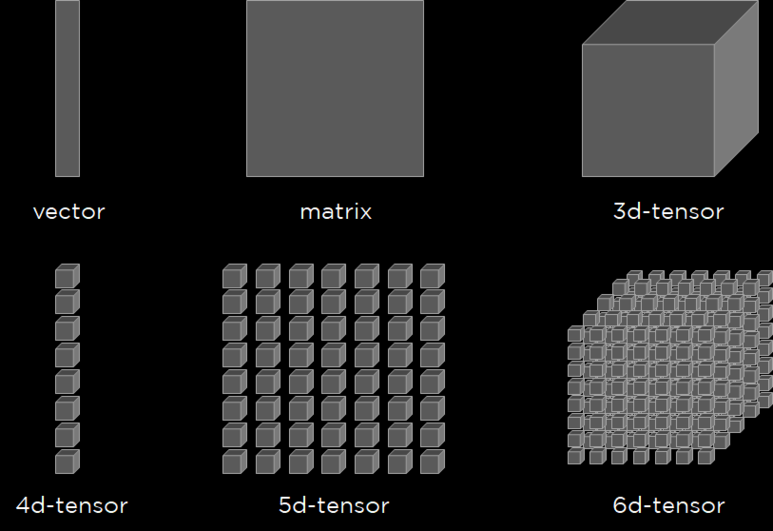

### ▶ 딥러닝 과정：데이터 전처리 → 인공지능 학습 → 평가

### 1) 데이터 전처리

우선 필요한 구성요소를 import 하는 것 부터 시작하겠다.

In [24]:
# os: Operating System의 줄임말로, 운영체제에서 제공되는 여러 기능을 파이썬에서 사용할 수 있도록 함
#  (Ex. 디렉토리 경로 이동, 시스템 환경 변수 가져오기 등)

# re: Regular Expression의 줄임말로, 파이썬 정규표현식을 사용하기 위한 모듈

# numpy(NumPy): 행렬이나 대규모 다차원 배열을 쉽게 처리할 수 있도록 지원하는 라이브러리. 
# 데이터 구조 외에도 수치 계산을 위해 효율적으로 구현된 기능을 제공

# tensorflow(TensorFlow): 데이터 흐름 프로그래밍을 위한 라이브러리. 
# 데이터 그래프를 수치적으로 연산하기 위해 구글에서 만든 오픈 소스 라이브러리.
import os, re 
import numpy as np
import tensorflow as tf

# glob 모듈의 glob 함수는 사용자가 제시한 조건에 맞는 파일명을 리스트 형식으로 반환한다
import glob  

print(tf.__version__)

2.8.2


#### 1-1. 가사 텍스트 파일 가져오기

가사 텍스트 파일은 49개의 파일로 이루어져있으며, 전체 용량은 6.4MB 가 조금 넘는 용량이다.

영문자나 공백, 특수문자등이 1 byte 의 크기를 갖는다고 가정했을때

글자, 공백이나 특수문자등을 반영한 전체 글자수는 약 645만개 가량의 분량으로 볼 수 있다.

In [30]:

## os.getenv(x)함수는 환경 변수x의 값을 포함하는 문자열 변수를 반환합니다. 
## txt_file_path 에 "/root/aiffel/lyricist/data/lyrics/*" 저장
# txt_file_path = "./lyricist/data/lyrics/*"
txt_file_path = "/content/drive/MyDrive/Colab Notebooks/EXP_06/lyricist/Data/lyrics/*"

# txt_file_path 경로에 있는 모든 파일명을 리스트 형식으로 txt_list 에 할당
txt_list = glob.glob(txt_file_path) 

raw_corpus = [] 

# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r", encoding="utf-8") as f:
        # print(txt_file)
        # read() : 파일 전체의 내용을 하나의 문자열로 읽어온다.
        # splitlines()  : 여러라인으로 구분되어 있는 문자열을 한라인씩 분리하여 리스트로 반환
        raw = f.read().splitlines() 
        # extend() : 리스트함수로 추가적인 내용을 연장 한다.
        raw_corpus.extend(raw)

print(" 데이터 크기 :", len(raw_corpus))
print(" Examples :\n", raw_corpus[:3])

 데이터 크기 : 187087
 Examples :
 ['"Don\'t worry about a thing,', "'Cause every little thing gonna be all right.", 'Singin\': "Don\'t worry about a thing,']


◆ preprocess_sentence：문장 전처리를 위한 함수

입력된 문장을 여러가지 전처리 하는 부분이다.

추가적으로 특수문자에서 더 확인 해야 할 부분이 있어서 검사해보았다.

In [120]:
# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다

# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

# 이 문장이 어떻게 필터링되는지 확인해 보세요.
print(preprocess_sentence("This @_is ;;;sample!       sentence. mind? kind, bind. \` \' \""))

<start> this is sample ! sentence . mind ? kind , bind . <end>


◆ 정제된 문장을 모으는 코드는 다음과 같다.

변경점은 3개 이다.

1. 문장 한 줄을 읽을때 혹시 모르는 공백이 자리를 차지할 수 있으니, 미리 제거해본 후에 길이를 확인하도록 변경했다.<br>
 - 『if len(sentence.strip()) == 0』 부분

2. 극본의 대사같은 내용이 아니므로, 「：」문자에 대한 분류 부분을 사용하지 않도록 함.<br>
 - 『if sentence[-1] == ":"』 부분

3. 〈권고사항〉토큰의 개수가 15개를 넘길 경우에 학습데이터에서 제외 시키기：<br>
공백문자가 15개 일때, 16개의 토큰이 생성 될 것이다, \<start\> \<end\> 문장 앞 뒤에 붙음.<br>
토큰 갯수가 16개 부터 제외시키는 방법으로 설정
 - 『if len(preprocessed_sentence.split(" ")) > 15』 부분

In [121]:
# 여기에 정제된 문장을 모을겁니다
corpus = []
excluded_sentences = []     ## 여기서는 제외된 문장을 모을겁니다.

# raw_corpus list에 저장된 문장들을 순서대로 반환하여 sentence에 저장
for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence.strip()) == 0:
        continue
    # if sentence[-1] == ":": 
    #     continue
    
    # 앞서 구현한 preprocess_sentence() 함수를 이용하여 문장을 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence.strip())

    if len(preprocessed_sentence.split(" ")) > 15:
        # print("◈ 토큰의 개수가 15개를 넘겨서 학습 데이터에서 제외함：")
        # print(preprocessed_sentence)
        # print("━" * 64)
        ## ◈ 토큰의 개수가 15개를 넘어가는 문장은 학습 데이터에서 제외한다. 
        excluded_sentences.append(preprocessed_sentence)  ## 그리고 여기에 모은다.
        continue

    corpus.append(preprocessed_sentence)

토큰 갯수를 어느정도 가계산 해서 사용할 문장과 사용하지 않을 문장을 분류해 놓았다.

10개정도만 출력해보았다.

In [122]:
# 정제된 결과를 10개만 확인해보죠
corpus[:10]

['<start> don t worry about a thing , <end>',
 '<start> cause every little thing gonna be all right . <end>',
 '<start> singin don t worry about a thing , <end>',
 '<start> smiled with the risin sun , <end>',
 '<start> three little birds <end>',
 '<start> perch by my doorstep <end>',
 '<start> singin sweet songs <end>',
 '<start> of melodies pure and true , <end>',
 '<start> cause every little thing gonna be all right . <end>',
 '<start> singin don t worry don t worry bout a thing , <end>']

정제된 문장 데이터와, 제외된 문장 데이터들을 좀 더 보다보면,

가사가 후렴구 처럼 반복되는 문장들이 있다.

이 부분을 전처리를 하지 않으면 후렴구의 반복되는 문장(가사)들이,

아무래도 통계적으로 더 사용 빈도가 높아질테니 전처리를 할까도 고민을 많이 했었다.

다만 순환신경망의 특성상, 다음에 올 단어들을 통계적 관점으로 접근하는 로직이므로,

반복되는 후렴구가 많다고 해서 굳이 그부분을 삭제한다거나 하는 조정의 필요까지는 없어 보였다.

오히려 이런 반복이 더 많으면 학습 과정에서 다음에 나올 단어들 예측해 보는 모델이기 때문에,

이러한 반복 학습은, 루브릭 기준 val_loss 만족하기에 더 유리할 것이라고 생각이 들기도 했다

In [123]:
## 제외된 결과를 10개만 확인해보죠
excluded_sentences[:10]

['<start> cause every little thing gonna be all right ! rise up this mornin , <end>',
 '<start> sayin , this is my message to you ou ou singin don t worry bout a thing , <end>',
 '<start> cause every little thing gonna be all right ! rise up this mornin , <end>',
 '<start> sayin , this is my message to you ou ou singin don t worry about a thing , worry about a thing , oh ! <end>',
 '<start> cause every little thing gonna be all right . singin don t worry about a thing , <end>',
 '<start> cause every little thing gonna be all right ! fadeout here is a little song i wrote <end>',
 '<start> don t worry , be happy . . . . . . ain t got no place to lay your head <end>',
 '<start> so don t worry , be happy now . . . . . there is this little song i wrote <end>',
 '<start> sayin , give thanks and praise to the lord and i will feel all right <end>',
 '<start> whoa , whoa , whoa , whoa let them all pass all their dirty remarks one love <end>']

제외된 결과에서 보니, 약간씩 아쉬운 부분이 보인다.

『.....』 만 해도 『…』 로 바꾸게 되면,

토큰 길이로 제외된 문장들 중에서 약간이지만 유효 문장(데이터 수)을 더 가져가는게 가능해 보인다.

다만, 실제로는 큰 효과가 있을 것 같지는 않다는 생각이다.

혹시 모델 평가 이후에 도저히 루브릭 달성이 어렵다는 생각이 든다면,

다시 처음부터 재시도 할 때에, 전처리 과정에서 데이터를 조금 더 면밀히 살펴보고

이런 점들을 살리는 방향으로 진행 해 보도록 하는걸로 하고, 일단은 넘어가도록 하자.

아래에서는 데이터를 토큰화 하기 위한 tokenize 함수를 약간 변경하여 재정의 한다.

우선, 단어 사전을 기존 7000 단어에서 12000 단어로 변경하였다.

그리고 앞서 15개 이상의 토큰을 제외하도록 앞서 sentences 전처리 과정에서

corpus.append 부분에서 걸러지도록 적용을 해 놓았었는데,

pad_sequences 함수의 padding 에 대해서 알아보는 과정에서 maxlen 매개변수를 사용하여

토큰의 길이를 제한 할 수도 있다는 내용을 확인 할 수 있었다.

앞서 sentences 전처리 과정에서 토큰이 15개 넘어가면 사용하지 않도록 적용을 해 놨기 때문에,

딱히 동작 할 일은 없겠지만, pad_sequences 함수에 maxlen 도 파라메터에 추가하였다.

maxlen 적용에 따라 truncating 부분도 추가 해 두었다. 동작 할 일은 없을 것 같지만.

- tf.keras.preprocessing.text.Tokenizer：텍스트 토큰화 유틸리티 클래스 이다.<br>
  
  + tokenizer 는 이 유틸리티 클래스의 인스턴스 이다.

  + num_words：단어 빈도에 따라 유지할 최대 단어의 수.<br>
  일반적으로 num_words - 1 개의 단어를 유지한다.

  + filters：각 요소가 텍스트에서 필터링될 문자인 문자열.

  + oov_token：딕셔너리에 토큰화 되어 있지 않은 단어를 대체하는 데 사용<br>
  지정하지 않은 경우, 딕셔너리 안에 토큰화 되어 있지 않은 단어는 정수 시퀀스에 포함되지 않는다. <br>
  지정한 경우, word_index 에 추가되고 text_to_sequence 호출 중에<br>
  딕셔너리에 토큰화 되어 있지 않은 단어를 대체하는 데 사용.

  + fit_on_texts：텍스트의 목록을 베이스로 내부 어휘를 업데이트 한다.<br>
  리스트에 텍스트가 포함된 경우, 각 항목들을 토큰이라고 보면 된다.<br>
  후술할 texts_to_sequences 를 사용하기 전에 fit_on_text 과정이 필요하다.

  + texts_to_sequences：텍스트들의 각 텍스트를 정수 시퀀스로 변환한다.<br>
  가장 자주 쓰이는 상위 num_words - 1 개의 단어만 다룬다.<br>
  토크나이저가 알고 있는 단어만 다룬다.

- tf.keras.preprocessing.sequence.pad_sequences：시퀀스 데이터를 사전 처리하기 위한 유틸리티.
  
  + pad_sequences：시퀀스를 동일한 길이로 채운다.

  + padding：문자열, "pre" 또는 "post"(선택 사항, 기본값은 "pre") - 각 시퀀스 앞이나 뒤를 채운다.

  + maxlen：선택적 Int, 모든 시퀀스의 최대 길이.<br>
  제공하지 않으면 시퀀스가 ​​가장 긴 개별 시퀀스의 길이로 맞춰서 채워진다.

  + truncating：문자열, "pre"는 길이가 초과됐을 때 앞쪽을 자르고,<br>
  "post"는 maxlen보다 큰 시퀀스의 끝의 값들을 제거한다.

In [4]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    
    # 12000 단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 12000 단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )

    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    # tokenizer.fit_on_texts(texts): 문자 데이터를 입력받아 리스트의 형태로 변환하는 메서드
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    # tokenizer.texts_to_sequences(texts): 텍스트 안의 단어들을 숫자의 시퀀스 형태로 변환하는 메서드
    tensor = tokenizer.texts_to_sequences(corpus)   

    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(
        tensor, padding="post", maxlen=15, truncating="post")
        
    print(tensor,tokenizer)
    
    return tensor, tokenizer

pad_sequences 의 padding 매개변수를 아무것도 지정하지 않는다면 기본값인 padding='pre' 가 적용된다.

padding='post' 와의 차이는 다음의 예시와 같다.

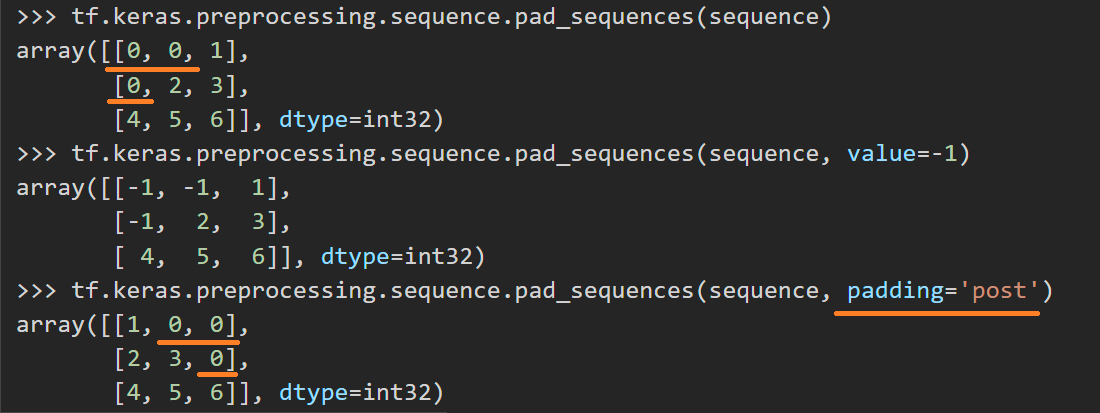

pre, post 의 차이점을, 실제 배열안에서 0 으로 패딩이 된 부분을 통해 확인 할 수 있다.

가운데의 예시를 통해, 0 이 아닌 다른 숫자 값으로 패딩 값을 설정 할 수 있는 것도 알 수 있다.

아직까진 문제 없이 잘 진행되고 있다.

아래에서 데이터를 토큰화 한다.

In [125]:
tensor, tokenizer = tokenize(corpus)

[[   2   40   16 ...    0    0    0]
 [   2   66  124 ...    0    0    0]
 [   2 1520   40 ...    0    0    0]
 ...
 [   2  540   19 ...    0    0    0]
 [   2  123   34 ...    0    0    0]
 [   2    4   24 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7f63f97172d0>


이 정수 인덱스들이 의미하는 단어가 무엇인지 확인하려면

단어사전의 내용을 확인 해 보면 된다.

tokenizer.index_word 는 단어의 인덱스와, 그에 해당하는 단어를

dictionary 형태로 반환한다.

이하의 코드를 참고하자.

In [126]:
print(type(tokenizer))
print(type(tokenizer.index_word))

# tokenizer.index_word: 현재 계산된 단어의 인덱스와
# 인덱스에 해당하는 단어를 dictionary 형대로 반환
#  (Ex. {index: '~~', index: '~~', ...})
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

<class 'keras_preprocessing.text.Tokenizer'>
<class 'dict'>
1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [127]:
print("tensor shape :" ,tensor.shape)
tensor

tensor shape : (156196, 15)


array([[   2,   40,   16, ...,    0,    0,    0],
       [   2,   66,  124, ...,    0,    0,    0],
       [   2, 1520,   40, ...,    0,    0,    0],
       ...,
       [   2,  540,   19, ...,    0,    0,    0],
       [   2,  123,   34, ...,    0,    0,    0],
       [   2,    4,   24, ...,    0,    0,    0]], dtype=int32)

토큰 수 조정이 잘 된 것을 확인 할 수 있다.

다시 텐서를 살펴보면, 시작은 2 ( = \<start\>) 로 되어있고, 

사전에서는 0 값이 없지만, 남은 부분은 0 ( = 패딩) 채워져 있는 모습을 확인 할 수 있다.

나중에 0 은 \<pad\> 로 바꾸게 될 것이다.

이제 훈련 데이터와 테스트 데이터를 만들어야 하는데,

여기서 훈련 데이터는 \<start\> 로 시작하는 부분을 포함하는데,

테스트 데이터는 맨 처음 \<start\> 를 제외한 나머지 부분이다.

In [128]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]    

print("    len(src_input) :", len(src_input))
print("    len(tgt_input) :", len(tgt_input))

print_index = 0
print(src_input[print_index])
print(tgt_input[print_index])

    len(src_input) : 156196
    len(tgt_input) : 156196
[  2  40  16 700 112   9 183   5   3   0   0   0   0   0]
[ 40  16 700 112   9 183   5   3   0   0   0   0   0   0]


우선, 훈련데이터랑 타겟데이터의 길이가 동일한 것을 알 수 있다.

데이터의 내용을 출력 해 보면, 훈련에 사용할 데이터는

맨 앞의 토큰 인덱스 2：\<start\> 가 타겟에는 없는 것을 확인할 수 있다.

타겟은 인덱스 2 로 시작하지 않고, 소스의 내용을 왼쪽으로 한칸 시프트 한 형태이다.

이제 검증과 시각화 내용을 확인하기 위해 검증용 데이터도 함께 분리하겠다.

scikit-learn 의 train_test_split 함수를 사용할 것이다.

enc_train, enc_val, dec_train, dec_val 데이터는 각각

x_train, y_train, x_test, y_test 의 용도에 대응한다 보면 되겠다.<br>
(혹은 x_train, x_valid, y_train, y_valid)

In [129]:
## sklearn 모듈의 train_test_split() 함수를 사용하여
from sklearn.model_selection import train_test_split
## 훈련 데이터와 평가 데이터를 분리
## 총 데이터의 20% 를 평가 데이터셋으로 사용
enc_train, enc_val, dec_train, dec_val = \
    train_test_split(src_input, tgt_input, test_size=0.2, random_state=75)

In [130]:
print("len(enc_train) :", len(enc_train), "    ", "shape :", enc_train.shape)
print("len(enc_val) :", len(enc_val), "    ", "shape :", enc_val.shape)
print("len(dec_train) :", len(dec_train), "    ", "shape :", dec_train.shape)
print("len(dec_val) :", len(dec_val), "    ", "shape :", dec_val.shape)
print("test_size＝0.2 확인 → 156196 * 0.2 ＝", 156196*0.2)

len(enc_train) : 124956      shape : (124956, 14)
len(enc_val) : 31240      shape : (31240, 14)
len(dec_train) : 124956      shape : (124956, 14)
len(dec_val) : 31240      shape : (31240, 14)
test_size＝0.2 확인 → 156196 * 0.2 ＝ 31239.2


갯수를 확인 해 보니,

테스트용으로 20％에 알맞게 분할 된 것을 확인할 수 있다.

In [131]:
print("enc_train :", enc_train[0])  ## x_train
print("enc_val :", enc_val[0])      ## x_test
print("dec_train :", dec_train[0])  ## y_train
print("dec_val :", dec_val[0])      ## y_test

enc_train : [    2   384   187   432   100   122 11074   647    52     3     0     0
     0     0]
enc_val : [   2 3614  105  247   17  647    3    0    0    0    0    0    0    0]
dec_train : [  384   187   432   100   122 11074   647    52     3     0     0     0
     0     0]
dec_val : [3614  105  247   17  647    3    0    0    0    0    0    0    0    0]


▲ enc_ 부분에서 맨 앞의 토큰 제외하면, train, val 내용이 같은것을 확인 할 수 있다.

In [132]:
BUFFER_SIZE = len(src_input)
BATCH_SIZE = 256
steps_per_epoch = BUFFER_SIZE // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 12000개와, 여기 포함되지 않은 0:<pad>를 포함하여 12001개
 # tokenizer.num_words: 주어진 데이터의 문장들에서 빈도수가 높은 n개의 단어만 선택
 # tokenize() 함수에서 num_words를 12000 선언했기 때문에, tokenizer.num_words의 값은 12000
VOCAB_SIZE = tokenizer.num_words + 1   

In [133]:
print("BUFFER_SIZE :", BUFFER_SIZE)
print("BATCH_SIZE :", BATCH_SIZE)
print("steps_per_epoch :", steps_per_epoch)
print("VOCAB_SIZE :", VOCAB_SIZE)

BUFFER_SIZE : 156196
BATCH_SIZE : 256
steps_per_epoch : 610
VOCAB_SIZE : 12001


변수를 확인해 보면 다음과 같다.

- BUFFER_SIZE：훈련데이터, 평가데이터 모두 합친 전체 데이터의 갯수이다.

- BATCH_SIZE：한번에 처리할 작업 단위이다. 256 을 지정하면 한번에 256개 단위로 처리한다.

- steps_per_epoch：epoch (1회)가 몇 스텝으로 이루어지는지 BATCH_SIZE 를 통해 계산 해 본 것이다.

- VOCAB_SIZE：앞서 14000개 지정（token）했고, 여기 포함되지 않은 0：\<pad\> 포함하여 14001개 확인 할 수 있다.

tf.data.Dataset객체 생성

tf.data.Dataset객체는 텐서플로우에서 사용할 경우,

데이터 입력 파이프라인을 통한 속도 개선 및 각종 편의 기능을 제공하는 것으로 알려져있다.

여기서는 이미 데이터셋을 텐서 형태로 생성해 두었으므로, 

tf.data.Dataset.from_tensor_slices 메소드를 이용해 tf.data.Dataset객체를 생성하겠다.

- from_tensor_slices：지정된 텐서의 슬라이스 요소를 포함하는 데이터 집합을 만든다.

주어진 텐서는 첫 번째 차원을 따라 슬라이스 된다.

이 작업은 입력 텐서의 구조를 보존하여 각 텐서의 첫 번째 차원을 제거하고

이를 데이터 세트 차원으로 사용한다.

모든 입력 텐서는 __첫 번째 차원에서 동일한 크기를 가져야 한다.__

아까 출력 해 본 내용에서도 확인 할 수 있듯이,

Shape 를 통해 첫번째 차원이 동일한 크기임을 확인 가능하다.

~~~
len(enc_train) : 124956      shape : (124956, 14)
len(dec_train) : 124956      shape : (124956, 14)
len(enc_val) : 31240      shape : (31240, 14)
len(dec_val) : 31240      shape : (31240, 14)
~~~

여기서는 enc_train 과 dec_train 두 개의 텐서를 하나의 Dataset 객체로 결합한다.

마찬가지로 enc_val 과 dec_val 도 하나의 Dataset 객체로 만든다.

- shuffle：데이터셋의 요소를 무작위로 섞는다.

버퍼를 buffer_size 요소로 채운 다음, 이 버퍼에서 요소를 무작위로 샘플링하여 선택한 요소를 새 요소로 바꾼다.

완벽한 셔플링을 위해서는 데이터 세트의 전체 크기보다 크거나 같은 버퍼 크기가 필요하다.

매개변수로 조금 전에 확인한 BUFFER_SIZE (=데이터 세트의 전체 크기) 지정한다.

- batch：데이터세트의 연속 요소를 배치로 결합한다.

batch_size 매개변수에는 BATCH_SIZE 값을 지정한다. 단일 배치로 결합할 데이터셋 연속 요소 갯수를 의미.<br>
(↑번역기라 조금 애매함)

drop_remainder 매개변수는 True 값을 지정한다. 여기서 중요한 참고사항이 있는데,

TensorFlow 공식 문서의 내용 중, Dataset 관련한 부분 찾아보는 과정에서 

다른 Dataset 메소드나 그 메소드들의 매개변수들 중에서 유독 강조하고 있는 부분이 있다.

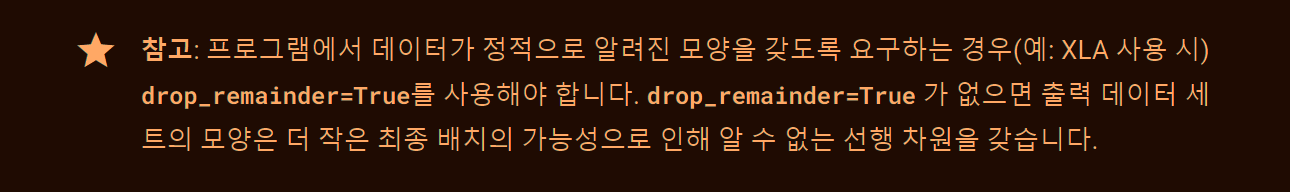

batch 에서 drop_remainder=True 지정하는 이유는, 

출력 데이터셋의 모양을 유지하기 위해서 사용함을 알 수 있다.

이 정도만 가볍게 알아보고 이제 데이터 셋을 만들고 다음 과정을 진행해보자.

데이터소스로부터 데이터셋을 만든다.

In [134]:
# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
train_ds = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
train_ds = train_ds.shuffle(BUFFER_SIZE)
train_ds = train_ds.batch(BATCH_SIZE, drop_remainder=True)

test_ds = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
test_ds = test_ds.shuffle(BUFFER_SIZE)
test_ds = test_ds.batch(BATCH_SIZE, drop_remainder=True)

만들어진 배치데이터셋의 타입을 알아보자.

In [135]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.BatchDataset

내용은 어떻게 이루어져 있을까

In [136]:
train_ds

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

내가 생각했던 것과 출력결과가 다르다. TensorSpec 이라니…

이 배치데이터셋이 어떤 구조로 되어 있는지 궁금해서 조사를 하는 도중

배치데이터셋의 내용을 보기 위한 [방법](https://stackoverflow.com/questions/62211655/python-data-ops-dataset-ops-batchdataset-how-to-use-it-to-create-training-and)을 찾을 수 있었다.

그 와중에, 우연히도 어떻게 내가 사용하고 있는 변수랑 이름이 같은지 참…

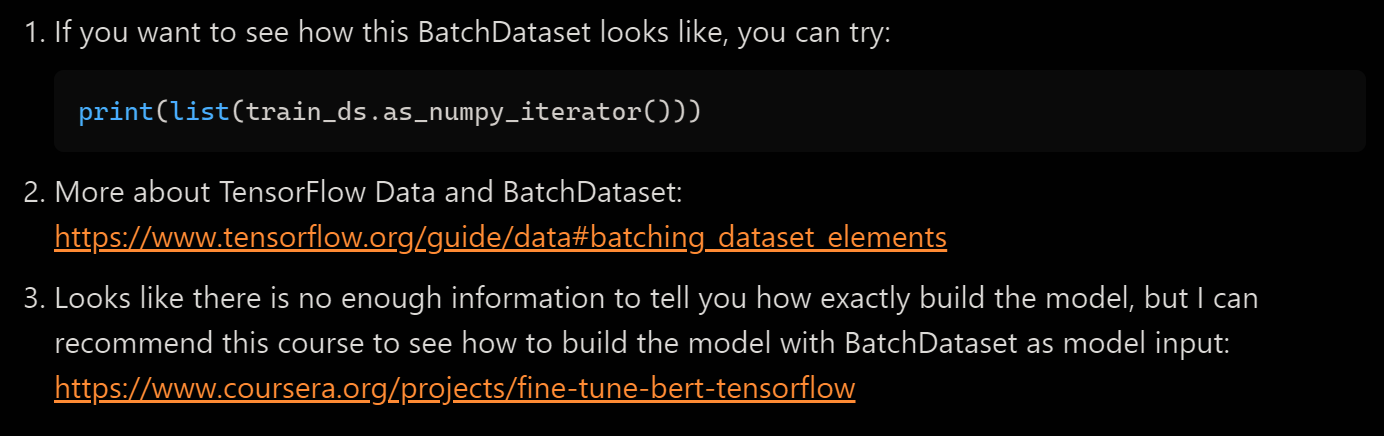

In [137]:
print(list(train_ds.as_numpy_iterator()))

[(array([[   2,  153,  538, ...,    0,    0,    0],
       [   2,   28,   19, ...,    0,    0,    0],
       [   2,  532,  237, ...,    0,    0,    0],
       ...,
       [   2,   37,   19, ...,    0,    0,    0],
       [   2,   63,    4, ...,    0,    0,    0],
       [   2, 1236,    5, ...,    0,    0,    0]], dtype=int32), array([[ 153,  538,    5, ...,    0,    0,    0],
       [  28,   19, 1122, ...,    0,    0,    0],
       [ 532,  237,  292, ...,    0,    0,    0],
       ...,
       [  37,   19, 1566, ...,    0,    0,    0],
       [  63,    4, 8198, ...,    0,    0,    0],
       [1236,    5, 1236, ...,    0,    0,    0]], dtype=int32)), (array([[   2,    4,   96, ...,    0,    0,    0],
       [   2,   59,  120, ...,    0,    0,    0],
       [   2,   45,   31, ...,    0,    0,    0],
       ...,
       [   2, 1028, 1389, ...,   17,    9,  658],
       [   2,  187,  316, ...,    0,    0,    0],
       [   2,    7,   63, ...,    0,    0,    0]], dtype=int32), array([[   4,  

여기까지 해서 전처리 과정은 마무리 하고 다음 과정으로 넘어가자.

모델의 구조도는 아래와 같다.

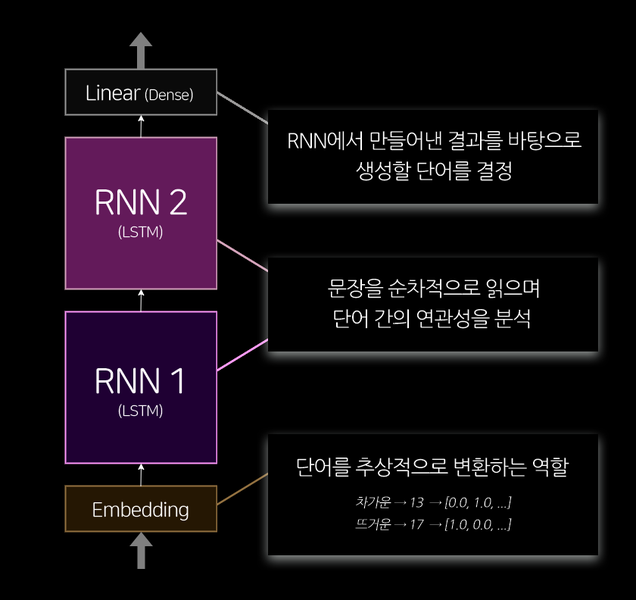

#### ■ 여기서 잠깐, RNN(LSTM) 의 개념에 대해서 살짝 알아보자.

LMS 노드상의 설명으로 이해가 잘 안되는 부분이 많았는데,

이하의 참고자료는, 그림을 통해 간단명료하게 해설을 해 놓은 편이라고 생각한다.

※ 참고 웹사이트 - [순환신경망](http://doc.mindscale.kr/km/unstructured/10.html)

수식이 조금 있지만, 상당히 이해하는데에 도움을 받았다.

※ 참고 웹사이트 - [RNN과 LSTM을 이해해보자!](https://ratsgo.github.io/natural%20language%20processing/2017/03/09/rnnlstm/)

이것은 RNN 과 LSTM 에 대해 아주 낱낱이 파헤친 자료이다.

솔직히 여기는 나에게는 너무 어려웠다. 수식만 봐도 어질어질하다.

이하의 코드들은 어려운 내용들이라 완전히 다 이해한것은 아니지만,

주석처리하여 설명을 많이 담아놓은 상태이다. 필요한 부분은 보충도 했다.

코드보다 주석이 텍스트량이 더 많은 것 같다.

LMS 컨텐츠 상에서도 그렇고, 주석에서도 가볍게 체험해 보는 정도로 넘어가자는 풍이라

변경이나 보충한 부분만 설명 하도록 하겠다.

- tf.keras.layers.Embedding：양의 정수(인덱스)를 고정 크기의 조밀한 벡터로 바꿈.

  + input_dim：정수. 어휘의 크기, 즉 최대 정수 인덱스 + 1. 여기서는 첫번째 파라메터, vocab_size 값을 지정.

  + output_dim：정수. Dense embedding 의 차원. 여기서는 두번째 파라메터, embedding_size 값을 지정.

- tf.keras.layers.LSTM：Long Short-Term Memory layer - Hochreiter 1997.<br>
(공식문서에 이렇게만 나와있다. 자세한 설명은 이전 블록들의 참고 웹사이트를 살펴보자)

  + units：양의 정수, 출력 공간의 차원. 첫번째 매개변수 자리이고 여기서는 hidden_size 값을 지정한다.

  + return_sequences：boolean. 출력 시퀀스의 마지막 출력을 반환할지, 전체 시퀀스를 반환할지의 여부. Default: False.<br>
  여기서는 return_sequences=True 로 지정하여, 모든 입력에 대해 출력을 내도록 한다.

  + 다른 매개변수들은 대부분 기본값 또는 사용하지 않지만,<br>
  [tf.keras 공식 문서](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM) 상의 내용에 따르면, 매개변수들 목록에서<br>
  각종 regularizer, dropout 도 찾아볼 수 있었다.
  
  + 이후 fit 과정에서, validation_loss 루브릭 조건 미달시, 과적합 이슈가 원인이라다면,<br>
  우선적으로 해당 파라메터를 신경망에 적용해 보는 것도 괜찮을 것 같다.

In [138]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        # Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성되어 있다.
        # Embedding 레이어는 단어 사전의 인덱스 값을 해당 인덱스 번째의 워드 벡터로 바꿔준다.
        # 이 워드 벡터는 의미 벡터 공간에서 단어의 추상적 표현으로 사용된다. 
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size) 
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)  
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
        
# embedding size 값이 커질수록 단어의 추상적인 특징들을 더 잡아낼 수 있지만
# 그만큼 충분한 데이터가 없으면 안좋은 결과 값을 가져옵니다!
# embedding_size = 256 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
# hidden_size = 1024 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.
embedding_size = 512 # 워드 벡터의 차원수를 말하며 단어가 추상적으로 표현되는 크기입니다.
hidden_size = 2048 # 모델에 얼마나 많은 일꾼을 둘 것인가? 정도로 이해하면 좋다.

# tokenizer.num_words에 +1인 이유는 문장에 없는 pad가 사용되었기 때문이다.
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size) 

In [139]:
# 데이터셋에서 데이터 한 배치만 불러오는 방법입니다.
# 지금은 동작 원리에 너무 빠져들지 마세요~
for enc_train, dec_train in train_ds.take(1): break

# 한 배치만 불러온 데이터를 모델에 넣어봅니다
model(enc_train)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-3.4755099e-05,  1.6989908e-04, -1.8669720e-04, ...,
          3.6808538e-05,  1.7284510e-04, -7.8260258e-05],
        [-5.4700009e-05,  2.5031675e-04, -4.3462627e-04, ...,
         -1.9779739e-04, -3.7875703e-05, -2.3721445e-04],
        [-1.2816885e-04,  1.0700123e-04, -9.9171733e-04, ...,
         -3.1320265e-04, -4.0950137e-04, -2.9002031e-04],
        ...,
        [-2.7667085e-04,  8.3384884e-04,  4.9529970e-04, ...,
         -1.3800197e-03,  2.5766643e-04, -7.9513935e-04],
        [-2.6989231e-04,  4.4881282e-04,  8.6833921e-04, ...,
         -1.5048550e-03,  5.2840781e-04, -7.2817033e-04],
        [-2.3687899e-04,  6.6114422e-05,  1.1626089e-03, ...,
         -1.6306229e-03,  7.5201428e-04, -6.6600327e-04]],

       [[-3.4755099e-05,  1.6989908e-04, -1.8669720e-04, ...,
          3.6808538e-05,  1.7284510e-04, -7.8260258e-05],
        [-5.3911841e-05,  1.7123349e-04, -2.4235442e-04, ...,
          4.7557766e-04, 

In [140]:
# 모델의 구조를 확인합니다.
model.summary()

Model: "text_generator_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_8 (Embedding)     multiple                  6144512   
                                                                 
 lstm_20 (LSTM)              multiple                  20979712  
                                                                 
 lstm_21 (LSTM)              multiple                  33562624  
                                                                 
 dense_8 (Dense)             multiple                  24590049  
                                                                 
Total params: 85,276,897
Trainable params: 85,276,897
Non-trainable params: 0
_________________________________________________________________


▶ 학습 전에 GPU는 안녕하신가？！

In [5]:
#tf.test.is_gpu_available() ## ← deprecated

import tensorflow as tf
tf.config.list_physical_devices('GPU')

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4099018337339638052
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1434114459
locality {
  bus_id: 1
  links {
  }
}
incarnation: 11335326073878801104
physical_device_desc: "device: 0, name: NVIDIA GeForce 930MX, pci bus id: 0000:01:00.0, compute capability: 5.0"
xla_global_id: 416903419
]


※ 잠깐, GPU 사용하면 최상의 성능을 얻을 수 있지만 문제가 발생 할 수 있다.

나도 한번 겪었는데, 그때는 하루 날리고 해결 방법을 찾지 못했었지만, 많이 알아봤다. 이제는 말할 수 있다.

이거때문에 모델 학습도 안되고 진짜 얼마나 고생을 했는지… 기억해두면 쓸모 있을 것 같다.

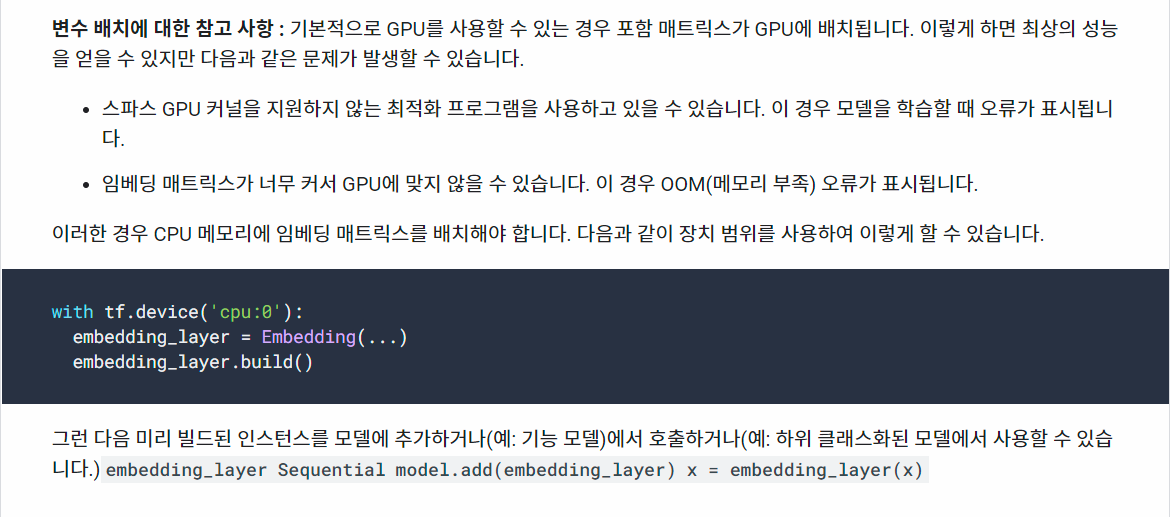

Loss 는 SparseCategoricalCrossentropy 를 사용하는데, 이것은 일단 그런가보다 하고 넘어가겠다.

LMS 컨텐츠에서 나중에 차차 배울거라고 하는데, 혹시 알고 싶다면 또 링크가 있긴 하다.

그치만 양도 많고 지금 보는 것을 추천하지 않는다고 한다.

마침 잘 됐다, 학습을 앞두고 있는 상황이라ㅡ 그런거 알아보는거 보다 빨리 학습먼저 돌려봐야지, 못 참는다.

In [142]:
#Loss
# tf.keras.losses.SparseCategoricalCrossentropy : 
# https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy
loss = tf.keras.losses.SparseCategoricalCrossentropy( 
    from_logits=True, reduction='none') 
    
# 클래스 분류 문제에서
# softmax 함수를 거치면 from_logits = False(default값),
# 그렇지 않으면 from_logits = True.

여기도 코드보다 주석이 차지하는 양이 훨씬 더 많다.

필요한 설명은 코드와 함께 적어놓았다.

In [143]:
# optimizer와 loss등은 차차 배웁니다
# 혹시 미리 알고 싶다면 아래 문서를 참고하세요
# https://www.tensorflow.org/api_docs/python/tf/keras/optimizers
# https://www.tensorflow.org/api_docs/python/tf/keras/losses
# 양이 상당히 많은 편이니 지금 보는 것은 추천하지 않습니다

# Adam 알고리즘을 구현하는 optimzier이며 어떤 optimzier를 써야할지 모른다면 Adam을 쓰는 것도 방법이다.
# 우리가 학습을 할 때 최대한 틀리지 않는 방향으로 학습을 해야한다.
# 여기서 얼마나 틀리는지(loss)를 알게하는 함수가 손실함수 이다.
# 이 손실함수의 최소값을 찾는 것을 학습의 목표로 하며 여기서 최소값을 찾아가는 과정을 optimization 이라하고
# 이를 수행하는 알고리즘을 optimizer(최적화)라고 한다.

optimizer = tf.keras.optimizers.Adam() # Adam은 현재 가장 많이 사용하는 옵티마이저이다. 자세한 내용은 차차 배운다.
loss = tf.keras.losses.SparseCategoricalCrossentropy( # 훈련 데이터의 라벨이 정수의 형태로 제공될 때 사용하는 손실함수이다.
    from_logits=True, # 기본값은 False이다. 모델에 의해 생성된 출력 값이 정규화되지 않았음을 손실 함수에 알려준다. 즉 softmax함수가 적용되지 않았다는걸 의미한다. 
    reduction='none'  # 기본값은 SUM이다. 각자 나오는 값의 반환 원할 때 None을 사용한다.
)

# 모델을 학습시키키 위한 학습과정을 설정하는 단계이다.
#model.compile(loss=loss, optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.
model.compile(loss=loss, metrics=["accuracy"], optimizer=optimizer) # 손실함수와 훈련과정을 설정했다.

## metrics 매개변수 지정하는 경우, model.fit 에서의 return 값인, History 객체에
## 모델이 훈련과 테스트를 진행하는 동안, (model.compile 매개변수에 metrics 지정이 있다면)
## metrics 에서 지정한 metrics 로 평가한다.
## 대부분 accuracy metrics 사용. Typically you will use metrics=['accuracy']  
## 이 프로젝트에서는 validation loss 값만 사용하므로 꼭 필요한건 아니다.

# 만들어둔 데이터셋으로 모델을 학습한다. 30번 학습을 반복하겠다는 의미다.
# model.fit(train_ds, epochs=30) 

## 만들어둔 데이터셋으로 모델을 학습한다. 10번 학습을 반복하겠다는 의미다.
## validation_data 매개변수로 검증을 위한 test 데이터셋인 test_ds 를 지정 
hresult = model.fit(train_ds, validation_data=test_ds, epochs=10) 

## modelfit Returns A History object. 
## History.history 속성은 검증 손실 값과 검증 메트릭 값(해당되는 경우)뿐만 아니라
## 연속적인 에포크에서의 훈련 손실 값 및 메트릭 값의 히스토리입니다.


Epoch 1/10
488/488 [==============================] - 142s 287ms/step - loss: 3.2821 - accuracy: 0.5019 - val_loss: 2.8943 - val_accuracy: 0.5312
Epoch 2/10
488/488 [==============================] - 139s 286ms/step - loss: 2.7263 - accuracy: 0.5426 - val_loss: 2.6337 - val_accuracy: 0.5550
Epoch 3/10
488/488 [==============================] - 139s 286ms/step - loss: 2.4014 - accuracy: 0.5717 - val_loss: 2.4575 - val_accuracy: 0.5775
Epoch 4/10
488/488 [==============================] - 139s 286ms/step - loss: 2.0862 - accuracy: 0.6088 - val_loss: 2.3204 - val_accuracy: 0.6007
Epoch 5/10
488/488 [==============================] - 139s 285ms/step - loss: 1.7948 - accuracy: 0.6520 - val_loss: 2.2251 - val_accuracy: 0.6217
Epoch 6/10
488/488 [==============================] - 139s 286ms/step - loss: 1.5397 - accuracy: 0.6972 - val_loss: 2.1630 - val_accuracy: 0.6409
Epoch 7/10
488/488 [==============================] - 139s 285ms/step - loss: 1.3326 - accuracy: 0.7373 - val_loss: 2.1350 -

epoch 10/10 까지 진행한 결과, validation loss 값은 2.1729 로 마무리 하였다.

val_loss 값이 마지막에 미미하게 증가하는 경향이 보여서 과적합의 가능성이 있었을 수도 있지만,

val_accuracy 값은 지속적으로 상승하고 있으며, 루브릭 조건도 달성한 상태이므로,

특별히 더 확인할 필요는 없을 것 같다.

사실, 이전 블럭에서, LSTM 레이어에 규제와 드롭아웃을 파라메터로 둘 수 있는것을 확인한 상태라,

과적합 문제의 경우는 해당 파라메터나 신경망에 레이어를 설정 해 볼 기회가 사라져 요만큼 아쉽긴 하지만,

학습에 너무 시간이 오래 걸리고, 지금 결과가 흐트러 질 수 있다 생각하니 아깝기도 하고,

프로젝트 마무리 이후에, 폐기함수를 제외 할 때 과적합이 발생하면, 한번 시도를 해 볼 수 있을 것 같다.

이하의 코드에 대한 설명도 블럭안에 충분히 들어가 있다.

- generate_text 는 문장들을 생성하는 함수이다.

- 『while True:』 loop 부분을 보면 뭔가 RNN 의 구조를 연상시킨다.<br>
처음 입력받은 값으로 단어(여기서는 정수로 표현)를 뽑아내서<br>
그 출력을 다시 입력으로 넣고 문장의 다음 구성요소를 또 뽑아내고<br>
그것을 계속 반복한다. 모델에서 문장의 끝맺음을 예측 할 때 까지.

- 『for word_index in test_tensor[0].numpy():』 loop 부분에서는<br>
단어 index 값 들로 이루어진 문장의 구성요소들을, tokenizer 를 통해<br>
인덱스와 매칭되는 단어를 찾아서 새 문자열에 붙여나간다.<br>
\<end\> 토큰 까지 변환을 마치고 최종적으로 generated 문자열을 반환한다.

In [144]:
#문장생성 함수 정의
#모델에게 시작 문장을 전달하면 모델이 시작 문장을 바탕으로 작문을 진행

#시작 문자열을 init_sentence 로 받으며 디폴트값은 <start> 를 받는다
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20): 
    
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    # 텍스트 안의 단어들을 숫자의 시퀀스의 형태로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence]) 
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다 
    #       (도달 하지 못하였으면 while 루프를 돌면서 다음 단어를 예측)
    while True: # 루프를 돌면서 init_sentence에 단어를 하나씩 생성
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4 
        if predict_word.numpy()[0] == end_token:
            break
        if test_tensor.shape[1] >= max_len:
            break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated #최종적으로 모델이 생성한 문장을 반환

그러면 이제 문장 생성을 시도해 보자.

In [148]:
generate_text(model, tokenizer, init_sentence="<start> i love", max_len=20)
# generate_text 함수에 lyricist 라 정의한 모델을 이용해서 ilove 로 시작되는 문장을 생성

'<start> i love the way you lie <end> '

번역기를 통하면 … "나는 당신이 거짓말 하는 방식을 사랑한다"

In [147]:
generate_text(model, tokenizer, init_sentence="<start> he", max_len=20)

'<start> he s a dancer in the dark <end> '

번역기를 통하면 … "그는 어둠속의 댄서"

In [149]:
generate_text(model, tokenizer, init_sentence="<start> we", max_len=20)

'<start> we re gonna get over <end> '

번역기를 통하면 … "우리는 극복할거야"

In [151]:
generate_text(model, tokenizer, init_sentence="<start> this", max_len=20)

'<start> this is the new america <end> '

번역기를 통하면 … "이것이 새로운 미국이다"

<hr>

### ■ 프로젝트 회고

#### 1) 이번 프로젝트에서 '어려웠던 점'

솔직히 RNN 과 LSTM 에 대한 개념이 지금도 너무 어렵다.

RNN, LSTM 이 어떤것인지는 대강 알 수 있었다.

그리고, 이것들이 멀리서 보면 어떻게 돌아가는지 대략적으로도 알 수 있었다.

다만, 어떻게 돌아가는지 자세히 알아보기 위해, 

히든 스테이트와 수식들에 대해서는 깊이 파고들 수 있지 못했다.

수포자는 웁니다.

그런데 진짜 문제는 따로 있었다.

뭐 공식문서 조금 찾아볼까 싶으면 __Deprecated (더 이상 사용되지 않는)__.

나를 화나게 하는 단어 __Deprecated__ …

더 이상 쓰이지도 않는 것을, 나는 왜 조사하고 공부하고 있는가？

그점이 진짜 학습 할 맛 안나고, 프로젝트 진행도중 계속 기운 빠지게 만들었다.

정신적으로 진짜 맥이 빠지는 경험 때문에 … 집중력이 떨어진 데다가, 아니 솔직히 꼴도 보기 싫다.

LMS 에서는 얻을 수 있는 정보가 부족했냐면, 그렇지는 않았다.

어차피 Deprecated 라고 해도, 문서의 링크는 유지되고 있었기 때문이다.

다만 외부 링크를 통해 여러 자료들을 참고하느라,

정보 수집을 위해 화면에 이곳저곳 띄워놓고 교차검증 정리하다보니,

Alt+Tab 으로는 답도 없고, 지금 FHD - 4K - FHD 디스플레이 3개 쓰고 있다.

이 프로젝트 노드 하느라 진짜 번거롭고 귀찮아 죽을 뻔 했다.

프로젝트 기간 중에도 내내 생각했고, 마무리 하는 지금 시점에서도 하는 생각은,

「NLP 가 어려운게 아니라, 노드의 컨텐츠 때문에 불편해서 꺼려하는게 아닐까…？」

#### 2) 프로젝트를 진행하면서 본인이 '학습한 내용'

학습한 내용들은 대부분 코드 전후와 본문에 기록을 해 두었다.

초반부 프로젝트 노드 필사 부분과 미니 프로젝트 과정,

본 프로젝트 과정 곳곳에 기록을 해 두었다.

하나도 모르겠어서, 대부분 찾아보고 공부를 해야만 했어서,

많은 부분에 걸쳐 내가 학습한 내용들 중 일부가 기록되어 있다.

귀찮거나 그렇게 중요한 내용같지는 않은 사소한 부분이라 기록을 안 한 것도 있지만…

가급적이면 많이 기록 해 두려고 했다.

프로젝트 진행 전에는 RNN, LSTM 에 대한 개념이 안잡혔었다.

그에 따라 지금 노드에 나오는 내용들 대부분에서 이해도가 낮았다.

토큰화？ LSTM？ 게다가 레이어 쌓는 방식도 지금까지 노드들하고 많이 달랐다.

이것도 학습 하는 과정에서 알게 된 것은, 이… 시퀀셜 모델만 봐와서 그런지,

- Sequential model (model.add(layer))

- Functional model (x = layer(x))

- subclassed model

이라는게 있다는 것이었다라거나…

뭐 이래저래 당황스러운 점들이 많았는데, 공부하면서

이번에는 퍼실 분들의 Tip 이 없었다면, 아마 RNN, LSTM 학습은 포기했을 것 같다.

프로젝트 시작 하던 시점에, 이런저런 점이 이해가 하나도 안되서

아무래도 이번에는 뭔가 망한것 같다고 퍼실님께 힘들다고 이야길 하니,

LMS 에서 부족했던 부분을 공부하기에 좋은 웹사이트를 추천해주셔서ㅡ

그 웹사이트를 통해 학습을 포기하지 않고 계속 해 나갈 수 있었다.

다른 정보들도 많이 검증하고 어떻게 정보 검색을 해 나갈지 깜깜했던 나에게

어두운 길의 등불과도 같았다고 생각한다.

그 웹사이트는 레퍼런스에도 기록해 두었다.

그것 말고도 한가지 더 팁을 얻었는데, 여기에선 사용하진 않았지만,

완전히 쌔까맣게 잊어버리고 있던 내용이어서 상당히 고마운 어드바이스 였다.

그것도 다시 학습하긴 했는데, 루브릭을 전부 달성해버렸네…

그래서 여기에 적용하지 않았다.

(했다가 오히려 안좋아지면… 그 오랜 학습시간을 어떻게 보상받나)

#### 3) 프로젝트를 진행하면서 '알아낸 점' 혹은 '아직 모호한 점'

알아낸 점들은 토큰화~ RNN … 등등 많은데 …

다른 교육생들과 이런저런 이야기도 하면서 또 조금씩 알게 된 것들도 많고 …

대부분은 위에 기록해서 그건 넘어가겠다.

모호한 점은, 계속 궁금했던 점인데, LSTM 속에서의 텐서가 진짜 어떻게 돌아가는지

생각해 보려고 해도 접근이 안되는 점이다.

배열의 관점에서 바라본 텐서를 이해하려고 노력하고ㅡ

이 프로젝트의 도중에서도 계속 텐서들을 찍어보려는 노력들을 했는데,

뭔가 더 깊이 알면 좋을거 같은데, 그렇게 파고 들려고 하면 사고회로가 정지된다.

설마, 더 알려고 들면 미쳐버릴까봐, 나를 보호하려고 더이상 생각을 못하도록 무의식이 저항하는 것인가？

텐서가 뭔지 알 것 같다가, 더 모르게 되는거 같다. 뭐가 어떻게 돌아가는 것인지…

그리고 학습에 걸리는 시간이

의외…가 아니라, 전혀 예상치 못한 정도로 굉장히 시간을 많이 잡아먹는거 같은데,

왜 그럴까？ 이런 저런 추측을 되짚어 보는데… 뭐 하나 선명하게 잡히는게 없다.

딥러닝은 너무 어렵다. 적어도 나한테는 블랙박스 맞는 것 같다.

#### 4) 루브릭 평가 지표를 맞추기 위해 '시도한 것들'

셰익스피어 데이터 보다 양적으로 자료가 많아서,

어느정도 늘어난 양에 걸맞게 파라메터 수치들을 키워준 것이 있다.

그리고 루브릭 평가 지표를 맞추기 위해 준비 해 둔 것들이 있는데,

지표에 들어서 사용은 안했지만, 아마 잘 안 풀렸다면

그것들을 하나 둘 셋 씩 적용하고… , 그래도 안되면

또 다른 준비 해 놓은 것을 한단계 두단계 적용하면서 시도를 해 봤을 것 같다.

의외로 사용할 일이 없어서 다행이라고 해야 할 지…

#### 5) 만약에 '루브릭 평가 지표를 달성하지 못했을 때, 이유에 관한 추정'

우선, 초반에 데이터 전처리 굉장히 중요하다.

그리고 다른거보다 우려스러운 점은

모델 학습 소요시간이 오래 걸린다는 점인데,

데이터 전처리가 미흡하면 나머지 과정에서 트러블이 아무래도 많을 것인데,

그에 더해서 학습 소요시간은 상당한 스트레스를 줄 것 같다.

그리고 파라메터 들에 대한 문제도 있다.

RNN, LSTM 에 대해서 이해가 전혀 없다가 공부를 하다보니 이 파라메터 문제로

예기치 못한 트러블이 발생할 수 있다.

실제로 나도 겪었는데, 이것에 대한 팁이 있다.

수치를 너무 많이 줬다가 망해버렸던 문제인데, 이것 때문에, 하루를 날렸다.

Embedding 부분이 원인이었고, 그 원흉은 파라메터 값들을 너무 크게 잡아둔 탓.

『GPU는 안녕하신가』 부분에 기록을 해 두었다.

급한 성격 때문에, GPU 최대한 활용하려다 보면 이런 일도 겪을 수 있을 것이다.

퍼실분들께도 이야기 했지만 마땅한 해결방법이나 원인을 알 수 없었는데,

트러블을 겪은 것은 나쁜 운이지만, 공부하다가 또 우연찮게 운이 좋아서,

그 문제에 대한 해결 방법을 발견 한것도 다행스러운 일이다.

그렇지만 나와 같은 문제를 겪은 데다가, 해결 방법도 운이 나빠서 발견 못한 상황이라면,

아마 프로젝트 자체를 마무리를 못하지 않을까 생각한다.

그정도 말고는…, 음 나같은 사람이나 욕심부리다가 트러블 겪은 것이겠지,

하란대로 노드 따라서 하고, 필요한거 적당히 코드 작성해서 학습 돌리고 결과 평가하고…

그런다면 어지간해서는 루브릭은 달성 할 수 있지 않나 생각한다.

#### 6) 자기 다짐

이번에는 트러블도 많고 힘들었어서, 무사히 마쳤다고 할 수 없지만, 

그래도 보통이하 조금 덜 만족스러운 수준에서, 다 완성하고 마치는것 까지는 했다.

이번 프로젝트 기간동안에는 나름 다른 교육생들에게 내가 아는 정보들도

가르쳐 줄 수 있기도 했고(로직 부분은 아니지만…), 다른 교육생들과

프로젝트 노드 관련해서 이야기 하면서 친분도 조금 두터워진 느낌이다.

초반부터 노드 학습 부분 내용 때문에 답답하고 의욕도 많이 떨어졌고,

프로젝트 시작 하려니 거의 망한 느낌이 들어서, 상당히 많이 흔들렸었다.

내용이 이해가 진짜 안가는 학습노드, 그것 때문에 화가 나서

도무지 프로젝트에 집중이 안되다보니, 정말 하기 싫었다.

프로젝트 반 줄 써내려가다가, 하기 싫다 그냥 잠이나 자자의 반복이었다.

그러다가 최근 갑자기 급 가속이 붙어서 어떻게 마무리 까지 오게 됐다.

화를 내니 스트레스를 많이 받고,

스트레스를 많이 받으니 잠을 자고 생각을 안하도록 해야

마음의 평온을 얻을 수 있는 법인데…

그러는 와중에도 프로젝트 마감 시간은 계속 다가오고, 해놓은건 없고…

그냥 화내는걸 포기했다.

그리고 그냥 내가 아는 내용으로 노드 채운다는 느낌으로

차근차근 진행하면서 문득 되돌아보니 또 그렇게 화낼 일이었나 싶었다.

명경지수의 마음을 유지하는 것이 쉽지는 않지만,

그래도 잠깐동안 명경지수 모드에 돌입했던 것이 긍정적인 효과를 낸 것 같다.

그리고 루브릭 달성을 위한, loss 기도 메타도 통했던 것 같다.

『나는 성격이 너무 급하니, 마음의 여유를 좀 가져야지』 라고 또 다짐해 보면서, 이만 마무리 하고자 한다.

<hr>

## ◎ Reference

- (AIFFEL) Exploration Project Node 06. 작사가 인공지능 만들기

- (TensorFlow) TensorFlow v2.10.0 API - [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras)

- (Tensor) Tensor 란？ - [[인공지능 개념] Tensor란 무엇인가?](https://rekt77.tistory.com/102)

- (RNN, LSTM) 순환신경망 - [10. 순환신경망](http://doc.mindscale.kr/km/unstructured/10.html)

<hr>

제게 영감을 주신 이강산님, 김유식님, 이평섭님, 구본회님 덕분에 이 험난했던 EXP_06 프로젝트를 극복할 수 있었습니다. 고맙습니다. 😊